# Google Colab-specific Setup

In [0]:
import gdown
from zipfile import ZipFile
gdown.download('https://drive.google.com/uc?export=download&id=11C8lWqT1Bqva_2NYkoGMqvX5ZF5SVJ4k', 'sls_data.zip', quiet=True)

with ZipFile('sls_data.zip', 'r') as zipObj:
   zipObj.extractall()

# Setup and Configuration

In [0]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("food.csv")
food = data['Food']
calories = data['Calories']
utility = data['Utility']
dict_calories = dict(zip(range(0,70),calories))
dict_utility = dict(zip(range(0,70),utility))
data.head()

,Food,Calories,Utility,Carbohydrate,Fat,Protein,Category
0,Murtabak,674,60,0.18,0.75,0.07,Others
1,Ee Mee Seafood (Fried),1010,90,0.31,0.54,0.15,Noodle
2,Nasi Goreng Sayur,920,50,0.67,0.27,0.06,Rice
3,Claypot Rice,896,80,0.41,0.37,0.21,Rice
4,Ban Mian,476,50,0.41,0.42,0.18,Others


In [0]:
def recombination(pop,childrenSize):
    recombination_pop = list()
    for n in range(0,int(childrenSize/2)):
        p1 = pop[random.randint(0,len(pop)-1)]
        p2 = pop[random.randint(0,len(pop)-1)]
        point = random.randint(0,20)
        c1 = np.append(p1[0:point],p2[point:]).tolist()
        c2 = np.append(p2[0:point],p1[point:]).tolist()
        recombination_pop.append(c1)
        recombination_pop.append(c2)

    return recombination_pop

def recombination2(pop,childrenSize):
    recombination_pop = list()
    for n in range(0,int(childrenSize/2)):
        p1 = pop[random.randint(0,len(pop)-1)]
        print(p1)
        p2 = pop[random.randint(0,len(pop)-1)]
        print(p2)
        point = np.random.choice(list(range(0,21)), 2,replace=False)
        print(point)
        print(point[0])
        print(point[1])
        if point[0] < point[1]:
            c1 = np.append(p1[0:int(point[0])],p2[int(point[0]):int(point[1])],p1[int(point[1]):]).tolist()
            c2 = np.append(p2[0:int(point[0])],p1[int(point[0]):int(point[1])],p2[int(point[1]):]).tolist()
         
        if point[0] > point[1]:
            c1 = np.append(p1[0:int(point[1])],p2[int(point[1]):int(point[0])],p1[int(point[0]):]).tolist()
            c2 = np.append(p2[0:int(point[1])],p1[int(point[1]):int(point[0])],p2[int(point[0]):]).tolist()
        
        recombination_pop.append(c1)
        recombination_pop.append(c2)
        
    return recombination_pop

In [0]:

def Gaussian(x):    # without mutation rate 
    N = np.random.randint(-34,34)
    xi = x + N
    if xi in range(0,69):
        return xi
    else:
        xi = x - N
        return xi
    
def mutation(recombination_pop):
    mutation_pop = list()
    for n in recombination_pop:
        chromosome = list()
        for x in n:
            xi = Gaussian(x)
            chromosome.append(xi)
        mutation_pop.append(chromosome)
    return mutation_pop

In [0]:
def correction(chromosome):

    foodnum = list(range(0,70)) # total food list 
    avail = list(set(foodnum)- set(chromosome)) # food list without existing chromosome
    
    repetition = list()
    for i,n in zip(chromosome,range(0,len(chromosome))):
        if chromosome[:n+1].count(i)>1:
            repetition.append((n))

    for i,n in zip(repetition,range(0,len(repetition))):
        chromosome[i] = np.random.choice(avail, len(repetition),replace=False)[n]
    return chromosome

In [0]:
# define fitness function
def get_utility(chromosome):
    week_utility = sum(list(map(dict_utility.get,chromosome)))
    return week_utility
  
# define constrain function
def get_calories(chromosome,constrain):    
    week_calories = sum(list(map(dict_calories.get,chromosome)))
    if week_calories <= constrain:
        return week_calories  # within the constrain 
    else:
        return 0  # eat too much calories


In [0]:
def selection(pop,populationSize,childrenSize,constrain):
    parents = pop
    children = mutation(recombination(parents,childrenSize))

    utility_list = list()
    calories_list = list()
    chromosome_list = list()
    
    # change selection method 
    for chromosome in (parents+children):
#     for chromosome in children:
        chromosome = correction(chromosome)
        utility_list.append(get_utility(chromosome))
        calories_list.append(get_calories(chromosome,constrain))
        chromosome_list.append(chromosome)

    # dataframe
    d = {'utility':utility_list, 'calories':calories_list,'chromosome': chromosome_list}
    df = pd.DataFrame(data=d, columns=['utility','calories','chromosome'])
    df = df[~df['calories'].isin([0])]
    df = df.sort_values(by='utility',ascending=False)
    df = df.iloc[0:populationSize]

    # max utility
    utility_max = df.iloc[0][0]
    
    # avg utility 
    utility_avg = sum(df.iloc[:,0])/ populationSize
    
    # calories for max utility
    calories_max = df.iloc[0][1]
    
    # food combination for max utility
    chromosome_max = df.iloc[0][2]
    plan = list()
    for i in chromosome_max:
        plan.append(data.iloc[int(i)][0])

    # genertate new population
    df = df.iloc[0:populationSize]['chromosome']
    pop = np.array(df).tolist() 

    return pop,utility_max,calories_max,plan,utility_avg

In [0]:
def main(pop,constrain,populationSize,numberOfGenerations,childrenSize):

    utility_list = list()
    avg_list = list()
    plan_list = list()
    for n in range(1,numberOfGenerations+1):

        pop,utility_max,calories_max,plan,utility_avg = selection(pop,populationSize,childrenSize,constrain)
        utility_list.append(utility_max)
        plan_list.append(plan)
        avg_list.append(utility_avg)
        print(f'generation: {n} ,utility_max: {utility_max}')
    print('') 
    print(f'Best Fitness Score: {max(utility_list)}')
    index = utility_list.index(max(utility_list))
    print('')    
    print('Recommended Menu for the week: ')
    print(plan_list[index])
    print('')   
    print(f'Average Daily Calories: {calories_max/7}')


    plt.figure(figsize=(10,5))
    plt.plot(utility_list, label='Max Fitness Score')
    plt.plot(avg_list, label='Avg Fitness Score')
    plt.ylabel('Fitness Score')
    plt.xlabel('Numbers of Iteration')
    plt.legend(loc='lower right')
    plt.show()

# ES Modeling

generation: 1 ,utility_max: 1370
generation: 2 ,utility_max: 1410
generation: 3 ,utility_max: 1410
generation: 4 ,utility_max: 1420
generation: 5 ,utility_max: 1430
generation: 6 ,utility_max: 1420
generation: 7 ,utility_max: 1480
generation: 8 ,utility_max: 1480
generation: 9 ,utility_max: 1480
generation: 10 ,utility_max: 1480
generation: 11 ,utility_max: 1480
generation: 12 ,utility_max: 1480
generation: 13 ,utility_max: 1480
generation: 14 ,utility_max: 1480
generation: 15 ,utility_max: 1480
generation: 16 ,utility_max: 1480
generation: 17 ,utility_max: 1480
generation: 18 ,utility_max: 1480
generation: 19 ,utility_max: 1480
generation: 20 ,utility_max: 1480
generation: 21 ,utility_max: 1480
generation: 22 ,utility_max: 1480
generation: 23 ,utility_max: 1480
generation: 24 ,utility_max: 1480
generation: 25 ,utility_max: 1480
generation: 26 ,utility_max: 1480
generation: 27 ,utility_max: 1480
generation: 28 ,utility_max: 1480
generation: 29 ,utility_max: 1480
generation: 30 ,utility

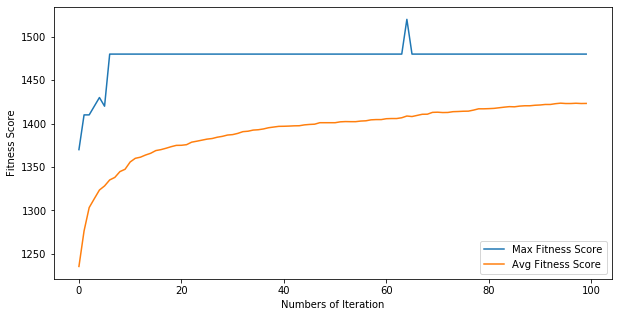

In [10]:
# ==================== Step 1 ==========================

populationSize = 50
pop = list()
for i in range(0,populationSize):
    pop.append(list(random.sample(range(0,69+1),21)))
    
#run main
main(pop,constrain = 1800 * 7, populationSize = 100,numberOfGenerations = 100,childrenSize = 200)

generation: 1 ,utility_max: 1450
generation: 2 ,utility_max: 1500
generation: 3 ,utility_max: 1500
generation: 4 ,utility_max: 1500
generation: 5 ,utility_max: 1500
generation: 6 ,utility_max: 1500
generation: 7 ,utility_max: 1500
generation: 8 ,utility_max: 1500
generation: 9 ,utility_max: 1500
generation: 10 ,utility_max: 1500
generation: 11 ,utility_max: 1500
generation: 12 ,utility_max: 1500
generation: 13 ,utility_max: 1520
generation: 14 ,utility_max: 1520
generation: 15 ,utility_max: 1520
generation: 16 ,utility_max: 1520
generation: 17 ,utility_max: 1520
generation: 18 ,utility_max: 1520
generation: 19 ,utility_max: 1520
generation: 20 ,utility_max: 1520
generation: 21 ,utility_max: 1520
generation: 22 ,utility_max: 1520
generation: 23 ,utility_max: 1520
generation: 24 ,utility_max: 1520
generation: 25 ,utility_max: 1520
generation: 26 ,utility_max: 1520
generation: 27 ,utility_max: 1520
generation: 28 ,utility_max: 1520
generation: 29 ,utility_max: 1520
generation: 30 ,utility

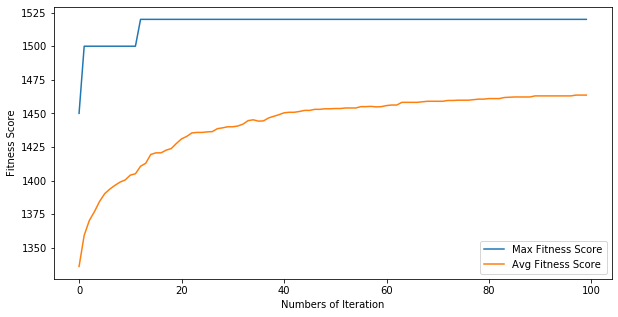

In [11]:
#==================== Step 2 ==========================

#run main
main(pop,constrain = 1800 * 7, populationSize = 50,numberOfGenerations = 100,childrenSize = 500)

generation: 1 ,utility_max: 1410
generation: 2 ,utility_max: 1400
generation: 3 ,utility_max: 1480
generation: 4 ,utility_max: 1400
generation: 5 ,utility_max: 1430
generation: 6 ,utility_max: 1430
generation: 7 ,utility_max: 1470
generation: 8 ,utility_max: 1480
generation: 9 ,utility_max: 1470
generation: 10 ,utility_max: 1410
generation: 11 ,utility_max: 1490
generation: 12 ,utility_max: 1430
generation: 13 ,utility_max: 1420
generation: 14 ,utility_max: 1410
generation: 15 ,utility_max: 1430
generation: 16 ,utility_max: 1420
generation: 17 ,utility_max: 1490
generation: 18 ,utility_max: 1440
generation: 19 ,utility_max: 1400
generation: 20 ,utility_max: 1430
generation: 21 ,utility_max: 1480
generation: 22 ,utility_max: 1430
generation: 23 ,utility_max: 1420
generation: 24 ,utility_max: 1470
generation: 25 ,utility_max: 1480
generation: 26 ,utility_max: 1420
generation: 27 ,utility_max: 1450
generation: 28 ,utility_max: 1440
generation: 29 ,utility_max: 1440
generation: 30 ,utility

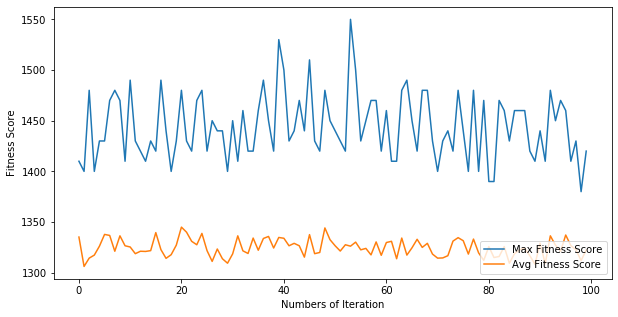

In [12]:
# ==================== Step 3 ==========================
def selection(pop,populationSize,childrenSize,constrain):
    parents = pop
    children = mutation(recombination(parents,childrenSize))

    utility_list = list()
    calories_list = list()
    chromosome_list = list()
    
    # change selection method 
#     for chromosome in (parents+children):
    for chromosome in children:
        chromosome = correction(chromosome)
        utility_list.append(get_utility(chromosome))
        calories_list.append(get_calories(chromosome,constrain))
        chromosome_list.append(chromosome)

    # dataframe
    d = {'utility':utility_list, 'calories':calories_list,'chromosome': chromosome_list}
    df = pd.DataFrame(data=d, columns=['utility','calories','chromosome'])
    df = df[~df['calories'].isin([0])]
    df = df.sort_values(by='utility',ascending=False)
    df = df.iloc[0:populationSize]

    # max utility
    utility_max = df.iloc[0][0]
    
    # avg utility 
    utility_avg = sum(df.iloc[:,0])/ populationSize
    
    # calories for max utility
    calories_max = df.iloc[0][1]
    
    # food combination for max utility
    chromosome_max = df.iloc[0][2]
    plan = list()
    for i in chromosome_max:
        plan.append(data.iloc[int(i)][0])

    # genertate new population
    df = df.iloc[0:populationSize]['chromosome']
    pop = np.array(df).tolist() 

    return pop,utility_max,calories_max,plan,utility_avg

# run main
main(pop,constrain = 1800 * 7, populationSize = 50,numberOfGenerations = 100,childrenSize = 500)

generation: 1 ,utility_max: 1390
generation: 2 ,utility_max: 1450
generation: 3 ,utility_max: 1520
generation: 4 ,utility_max: 1540
generation: 5 ,utility_max: 1540
generation: 6 ,utility_max: 1550
generation: 7 ,utility_max: 1560
generation: 8 ,utility_max: 1570
generation: 9 ,utility_max: 1590
generation: 10 ,utility_max: 1590
generation: 11 ,utility_max: 1590
generation: 12 ,utility_max: 1630
generation: 13 ,utility_max: 1630
generation: 14 ,utility_max: 1630
generation: 15 ,utility_max: 1630
generation: 16 ,utility_max: 1630
generation: 17 ,utility_max: 1630
generation: 18 ,utility_max: 1670
generation: 19 ,utility_max: 1670
generation: 20 ,utility_max: 1670
generation: 21 ,utility_max: 1670
generation: 22 ,utility_max: 1670
generation: 23 ,utility_max: 1670
generation: 24 ,utility_max: 1670
generation: 25 ,utility_max: 1670
generation: 26 ,utility_max: 1670
generation: 27 ,utility_max: 1670
generation: 28 ,utility_max: 1670
generation: 29 ,utility_max: 1670
generation: 30 ,utility

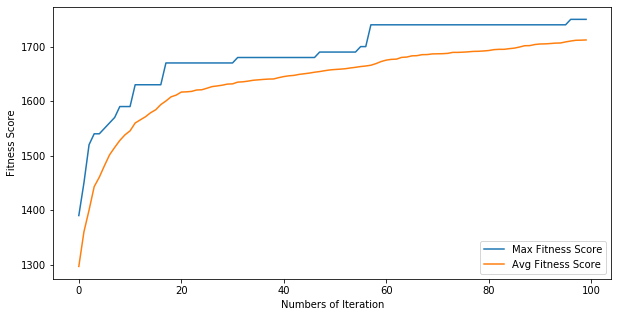

In [13]:
# ==================== Step 4 ==========================
def random_pick(some_list,probabilities):
    x = random.uniform(0,1)
    cumulative_probability=0.0
    for item,item_probability in zip(some_list,probabilities):
        cumulative_probability+=item_probability
        if x < cumulative_probability:
            break
    return item

def Gaussian(x):
    N = np.random.randint(-34,34)
    p = random_pick([1,0],[0.2,0.8])
    xi = x + p*N
    if xi in range(0,69):
        return xi
    else:
        xi = x - p*N
        return xi 

def mutation(recombination_pop):
    mutation_pop = list()
    for n in recombination_pop:
        chromosome = list()
        for x in n:
            xi = Gaussian(x)
            chromosome.append(xi)
        mutation_pop.append(chromosome)
    return mutation_pop


def selection(pop,populationSize,childrenSize,constrain):
    parents = pop
    children = mutation(recombination(parents,childrenSize))

    utility_list = list()
    calories_list = list()
    chromosome_list = list()
    
#     change selection method 
    for chromosome in (parents+children):
#     for chromosome in children:
        chromosome = correction(chromosome)
        utility_list.append(get_utility(chromosome))
        calories_list.append(get_calories(chromosome,constrain))
        chromosome_list.append(chromosome)

    # dataframe
    d = {'utility':utility_list, 'calories':calories_list,'chromosome': chromosome_list}
    df = pd.DataFrame(data=d, columns=['utility','calories','chromosome'])
    df = df[~df['calories'].isin([0])]
    df = df.sort_values(by='utility',ascending=False)
    df = df.iloc[0:populationSize]

    # max utility
    utility_max = df.iloc[0][0]
    
    # avg utility 
    utility_avg = sum(df.iloc[:,0])/ populationSize
    
    # calories for max utility
    calories_max = df.iloc[0][1]
    
    # food combination for max utility
    chromosome_max = df.iloc[0][2]
    plan = list()
    for i in chromosome_max:
        plan.append(data.iloc[int(i)][0])

    # genertate new population
    df = df.iloc[0:populationSize]['chromosome']
    pop = np.array(df).tolist() 

    return pop,utility_max,calories_max,plan,utility_avg

# initialize population
populationSize = 50
pop = list()
for i in range(0,populationSize):
    pop.append(list(random.sample(range(0,69+1),21)))
iter 
#run main
main(pop,constrain = 1800 * 7, populationSize = 50,numberOfGenerations = 100,childrenSize = 200)